In [1]:
import json
import os
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import pandas as pd

# Veri setinin yolu
dataset_path = '***'
label_path = 'label_jsons'

# Resimlerin ve etiketlerin listeleri
images = []
label_names = []
label_positions = []

# Veri setindeki tüm dosyaları döngüye al
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpeg'):
        
        
        # JSON dosyasının var olup olmadığını kontrol et
        json_filename = os.path.join(label_path, filename.replace('.jpeg', '.json'))
        if os.path.exists(json_filename):
            
            # Resmi oku ve yeniden boyutlandır
            img = cv2.imread(os.path.join(dataset_path, filename))
            img = cv2.resize(img, (256, 256))
            
            # JSON dosyasını oku ve etiketi al
            with open(json_filename, 'r') as f:
                data = json.load(f)
                label_names.append(data['shapes'][0]['label'])
                label_positions.append(np.array(data['shapes'][0]['points']).flatten())  # Köşe noktalarını bir numpy dizisine dönüştür
                       
                
            # Resmi ve etiketi listelere ekle
            images.append(img)

In [2]:
# Etiketleri one-hot kodlamaya dönüştür
label_df = pd.get_dummies(label_names)
label_names_encoded = label_df.values

# Sınıf adlarını bir liste olarak sakla
class_names = label_df.columns.tolist()

In [3]:
# Listeleri numpy dizilerine dönüştür
images = np.array(images)
label_names = np.array(label_names)
label_positions = np.array(label_positions)

In [4]:
#normalize images
images = images / 255.0

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense

# Giriş katmanı
input_layer = Input(shape=(256, 256, 3))

# Feature çıkarımı 
x = Conv2D(6, (5,5), activation='relu')(input_layer)
x = AveragePooling2D()(x)
x = Conv2D(16, (5,5), activation='relu')(x) 
x = AveragePooling2D()(x)

# Sınıf tahmini için output katmanı
class_output = Flatten()(x)  
class_output = Dense(120, activation='relu')(class_output)
class_output = Dense(84, activation='relu')(class_output)
class_output = Dense(6, activation='softmax')(class_output)

# Konum tahmini için output katmanı 
loc_output = Flatten()(x)
loc_output = Dense(60)(loc_output)
loc_output = Dense(8)(loc_output)

# Modeli birleştir
model = Model(inputs=input_layer, outputs=[class_output, loc_output])

# Kayıp fonksiyonları ve optimizasyon
model.compile(
  loss=['categorical_crossentropy', 'mse'], 
  optimizer='adam',
  metrics=['accuracy']
)

In [6]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of folds for cross-validation
num_folds = 3

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Define the K-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store the training and validation loss for each fold
train_loss_list = []
val_loss_list = []

# Loop over the folds
for fold, (train_indices, val_indices) in enumerate(kfold.split(images)):
    
    # Split the data into training and validation sets for this fold
    train_images, train_labels, train_positions = images[train_indices], label_names_encoded[train_indices], label_positions[train_indices]
    val_images, val_labels, val_positions = images[val_indices], label_names_encoded[val_indices], label_positions[val_indices]
    
    # Train the model for this fold
    history = model.fit(train_images, [train_labels, train_positions], epochs=100, batch_size=32, validation_data=(val_images, [val_labels, val_positions]), callbacks=[early_stop])
    
    # Store the training and validation loss for this fold
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])


Epoch 1/100
3/3 [==============================] - 4s 909ms/step - loss: 3944999.5000 - dense_2_loss: 2.7326 - dense_4_loss: 3944996.5000 - dense_2_accuracy: 0.1667 - dense_4_accuracy: 0.2143 - val_loss: 3826767.0000 - val_dense_2_loss: 2.3952 - val_dense_4_loss: 3826764.2500 - val_dense_2_accuracy: 0.1860 - val_dense_4_accuracy: 0.4419
Epoch 2/100
3/3 [==============================] - 2s 761ms/step - loss: 3804134.5000 - dense_2_loss: 1.8685 - dense_4_loss: 3804132.5000 - dense_2_accuracy: 0.3214 - dense_4_accuracy: 0.3214 - val_loss: 3576463.0000 - val_dense_2_loss: 1.8918 - val_dense_4_loss: 3576461.0000 - val_dense_2_accuracy: 0.3488 - val_dense_4_accuracy: 0.4419
Epoch 3/100
3/3 [==============================] - 2s 733ms/step - loss: 3476391.5000 - dense_2_loss: 1.6901 - dense_4_loss: 3476390.0000 - dense_2_accuracy: 0.3095 - dense_4_accuracy: 0.3214 - val_loss: 3090420.0000 - val_dense_2_loss: 2.7495 - val_dense_4_loss: 3090417.2500 - val_dense_2_accuracy: 0.3488 - val_dense_4_

C:\Users\baran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


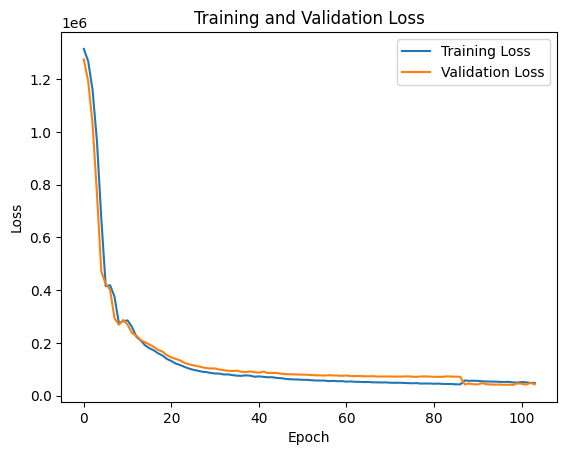

In [7]:
import matplotlib.pyplot as plt

# Calculate the average training and validation loss across all folds
avg_train_loss = np.mean(train_loss_list, axis=0)
avg_val_loss = np.mean(val_loss_list, axis=0)

# Plot the training and validation loss across all folds
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
#save model
model.save('C:/Users/baran/Desktop/***/cargo_model.keras')

In [9]:
import os
import cv2
import numpy as np

folder = 'C:/Users/baran/Desktop/***/half_181002'
i = 1
for filename in os.listdir(folder):
    if filename.endswith('.jpeg'):
        img_path = os.path.join(folder, filename)

        # Resmi okuyun ve yeniden boyutlandırın
        image = cv2.imread(img_path)
        image_resized = cv2.resize(image, (256, 256))

        # Resmi bir diziye dönüştürün ve boyutunu genişletin
        img_array = np.expand_dims(image_resized, axis=0)

        img_array = img_array / 255.0

        # Tahmini yapın
        name_prediction, position_prediction = model.predict(img_array)

        # Tahmin edilen etiketi alın
        predicted_index = np.argmax(name_prediction[0])
        predicted_class = class_names[predicted_index]

        # Get bounding box
        x_coords = position_prediction[0][::2]
        y_coords = position_prediction[0][1::2]

        x_min = min(x_coords)
        x_max = max(x_coords)
        y_min = min(y_coords) 
        y_max = max(y_coords)

        # Calculate text position
        x = int(x_min)
        y = int(y_min - (y_max - y_min)/4) 

        cv2.putText(image, 
                    predicted_class,
                    (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    4, 
                    (0,0,255),  
                    10)

        cv2.imwrite(img_path, image) # overwrite original image

        
        print(i)
        i = i + 1

1/1 [==============================] - 0s 207ms/step
1
1/1 [==============================] - 0s 50ms/step
2
1/1 [==============================] - 0s 46ms/step
3
1/1 [==============================] - 0s 43ms/step
4
1/1 [==============================] - 0s 43ms/step
5
1/1 [==============================] - 0s 50ms/step
6
1/1 [==============================] - 0s 41ms/step
7
1/1 [==============================] - 0s 43ms/step
8
1/1 [==============================] - 0s 48ms/step
9
1/1 [==============================] - 0s 35ms/step
10
1/1 [==============================] - 0s 43ms/step
11
1/1 [==============================] - 0s 43ms/step
12
1/1 [==============================] - 0s 40ms/step
13
1/1 [==============================] - 0s 36ms/step
14
1/1 [==============================] - 0s 42ms/step
15
1/1 [==============================] - 0s 44ms/step
16
1/1 [==============================] - 0s 39ms/step
17
1/1 [==============================] - 0s 42ms/step
18
1/1 [=============